# Logistic Regression Classification

In this notebook, I will explore how logistic regression performs with my both my binary and multiclass labels. I perform various experiments to evaluate the efficacy of logistic regression and ultimately find a model that performs well for pitchers that have a more even mixture of pitches compared to fastball dominant pitchers.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sklearn.metrics as metrics
import boto3
import math


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [2]:
random.seed(16)

## Reading in Binary and Multiclass DataFrames

In [3]:
# Specifying s3 as boto3 resource and connecting to bucket
s3 = boto3.resource('s3')
bucketname = 'baseballstats'

# Name of files within the bucket
binary_label = 'statcast_data/clean_2019_binary_label.csv'

# multiclass 2019 DataFrame
multiclass_label = 'statcast_data/clean_2019_3.csv'

# Specifying location of files
multiclass_obj = s3.Object(bucketname, multiclass_label)
binary_obj = s3.Object(bucketname, binary_label)

# Getting the body of the files
multiclass = multiclass_obj.get()['Body']
binary = binary_obj.get()['Body']

# Reading the boto3 object into a csv

# df is my default for binary labels
df = pd.read_csv(binary)

# df_3 is my default for 
df_3 = pd.read_csv(multiclass)

In [4]:
df.head()

,balls,strikes,on_1b,outs_when_up,inning,pitch,offspeed_in_sequence,fastball_in_sequence,proportion_of_fastballs_thrown_2018,previous_pitch,...,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
0,3.0,2.0,0.0,2.0,9.0,0,1,5,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819
1,3.0,2.0,0.0,2.0,9.0,1,1,4,0.558863,1,...,0,0,1,0,4.0,0,1,0,0.366304,90.160819
2,2.0,2.0,0.0,2.0,9.0,1,1,3,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819
3,2.0,1.0,0.0,2.0,9.0,1,1,2,0.558863,0,...,0,0,1,0,4.0,0,1,0,0.366304,90.160819
4,1.0,1.0,0.0,2.0,9.0,0,0,2,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819


In [5]:
df['pitch'].value_counts()

1    281249
0    200050
Name: pitch, dtype: int64

In [6]:
df.head()

,balls,strikes,on_1b,outs_when_up,inning,pitch,offspeed_in_sequence,fastball_in_sequence,proportion_of_fastballs_thrown_2018,previous_pitch,...,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
0,3.0,2.0,0.0,2.0,9.0,0,1,5,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819
1,3.0,2.0,0.0,2.0,9.0,1,1,4,0.558863,1,...,0,0,1,0,4.0,0,1,0,0.366304,90.160819
2,2.0,2.0,0.0,2.0,9.0,1,1,3,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819
3,2.0,1.0,0.0,2.0,9.0,1,1,2,0.558863,0,...,0,0,1,0,4.0,0,1,0,0.366304,90.160819
4,1.0,1.0,0.0,2.0,9.0,0,0,2,0.558863,1,...,0,0,1,0,4.0,0,0,1,0.366304,90.160819


In [7]:
# Baseline accuracy
df['pitch'].value_counts(normalize=True)

1    0.584354
0    0.415646
Name: pitch, dtype: float64

In [8]:
df.isna().sum()

balls                                   0
strikes                                 0
on_1b                                   0
outs_when_up                            0
inning                                  0
pitch                                   0
offspeed_in_sequence                    0
fastball_in_sequence                    0
proportion_of_fastballs_thrown_2018     0
previous_pitch                          0
previous_zone                           0
stand_R                                 0
p_throws_R                              0
if_fielding_alignment_Infield shift     0
if_fielding_alignment_Standard          0
of_fielding_alignment_4th outfielder    0
of_fielding_alignment_Standard          0
risp                                    0
run_diff                                0
inning_topbot_Top                       0
previous_type_B                         0
previous_type_S                         0
hitter_woba_2018                        0
average_hitter_launch_speed_2018  

In [9]:
def binary_classification_metrics(gs, X_test, y_test):
    
    y_hat = gs.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_hat) 

    sensitivity =  metrics.recall_score(y_test, y_hat)

    precision = metrics.precision_score(y_test, y_hat)
    

    f1 = metrics.f1_score(y_test, y_hat)
    
    
    print('My accuracy is: ', round(accuracy,4))
    print('My sensitivity is: ', round(sensitivity,4))
    print('My precision is: ', round(precision,4))
    print('My f1 score is: ', round(f1,4))
    
    cm = np.array([['True Negative', 'False Positive'],
                            ['False Negative', 'True Positive']])

    cm = pd.DataFrame(cm,columns = ['Pred Offspeed', 'Pred Fastball'], 
                      index = ['Actual Offspeed','Actual Fastball'])
    
    # Displaying sample confusion matrix
    display(cm)

    # Displaying actual confusion matrix 
    metrics.plot_confusion_matrix(gs, X_test, y_test, cmap='Accent', 
                          values_format='d', display_labels=['Offspeed Pitch', 
                                                             'Fastball Pitch']);
    
    metrics.plot_roc_curve(gs, X_test, y_test)
    # add worst case scenario line
    plt.plot([0, 1], [0, 1])
    plt.title('ROC AUC Curve');
    
    print(f'My ROC AUC score is: {metrics.roc_auc_score(y_test, y_hat)}')

In [10]:
# Creating independent and target variables
X = df.drop(columns=['pitch'])
y = df['pitch']

In [11]:
# Train-test-splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=16, stratify=y)

In [12]:
# Stratify ensures even distribution between the target labels
y_test.value_counts(normalize=True)

1    0.584351
0    0.415649
Name: pitch, dtype: float64

## First Experiments 
* Analyzing whether data passed in as is after cleaning presents good results or if I need to consider pre-processing to get rid of multicollinearity
* I experiments with both grid-searching over both the accuracy and weighted F1-score to determine if I can prevent over-predicting a fastball.

### Constructing Logistic Regression Pipeline 

In [13]:
# Constructing pipeline to train logistic regression model. Need to scale the 
# independent variables to ensure all features are unitless. 
pipe = Pipeline([
    
    ('mm', MinMaxScaler()),
    ('lr', LogisticRegression())
    
])

### First Parameters to Gridsearch Over

In [14]:
# Creating dictionary of parameters to gridsearch over
params = {
    'lr__solver': ['liblinear','saga'],
    'lr__penalty': ['l1','l2', 'elasticnet'],
    'lr__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__class_weight': [None, 'balanced']
}

### Gridsearching with F1_Weighted Scoring

By gridsearching with the F1_weighted scoring, I am maximizing the harmonic mean of the precision and recall score. It is my hope that by gridsearching with this scoring system I am able to minimize over-predicting a fastball.   

In [15]:
# Instantietating gridsearch with pipeline
gs_f1 = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='f1_weighted')

In [16]:
# Fitting first logistic regression model 
gs_f1.fit(X_train, y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 17.5min finished


My accuracy is:  0.5993
My sensitivity is:  0.5979
My precision is:  0.6783
My f1 score is:  0.6356


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.5996350597268877


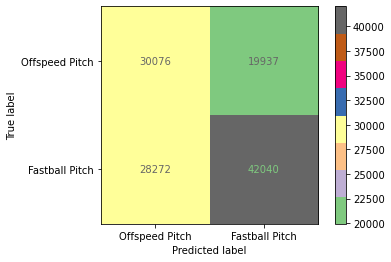

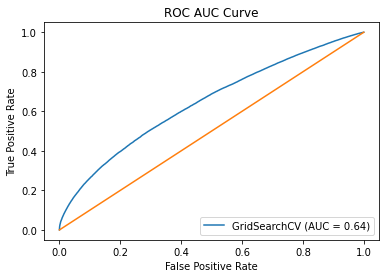

In [17]:
# Analyzing the classification metrics
binary_classification_metrics(gs_f1, X_test, y_test);

### Gridsearching with Accuracy Scoring

With this scoring system I am trying to maximize the total accuracy, even if that means over-predicting the fastball occurrence. 

In [18]:
gs_accuracy = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='accuracy')

In [19]:
gs_accuracy.fit(X_train, y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 16.4min finished


My accuracy is:  0.612
My sensitivity is:  0.8139
My precision is:  0.63
My f1 score is:  0.7103


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.5709791409973537


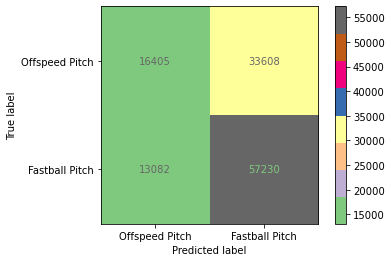

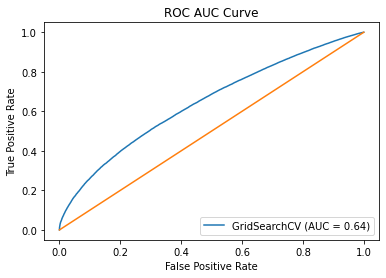

In [20]:
binary_classification_metrics(gs_accuracy, X_test, y_test);

## Logistic Regression with Dummy Variables 

In this section I wanted to evaluate whether some variables are better posed in a categorical rather than
continuous fashion. I initially assumed these variables had an ordinal nature, but that might not be the case.

In [21]:
# Getting dummy variables for numerical variables that might not have order

dummy_df = pd.get_dummies(data=df, columns=['balls', 'strikes', 'outs_when_up',
                                           'inning', 'previous_pitch', 
                                            'previous_zone'], drop_first=True)

In [22]:
X_4 = dummy_df.drop(columns = ['pitch'])
y_4 = dummy_df['pitch']

In [23]:
X_train_dum, X_test_dum, y_train_dum, y_test_dum = train_test_split(X_4, y_4, test_size=0.25, 
                                                    random_state=16, stratify=y)

### Logistic Regression with Dummy Variables and Weighted F1 scoring 

In [24]:
# Using same pipeline for the GridSearch 
gs_f2 = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='f1_weighted')

In [25]:
gs_f2.fit(X_train_dum, y_train_dum)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 95.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 98.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'lr__class_weight': [None, 'balanced'],
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['liblinear', 'saga']},
             scoring='f1_weighted', verbose=1)

My accuracy is:  0.601
My sensitivity is:  0.5898
My precision is:  0.684
My f1 score is:  0.6334


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.6033383418103988


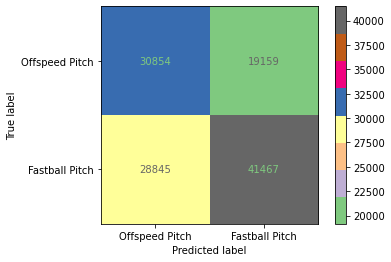

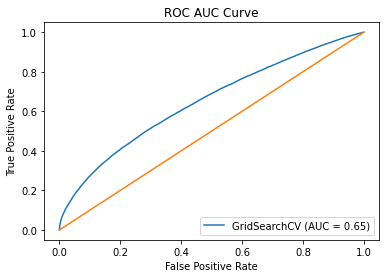

In [26]:
binary_classification_metrics(gs_f2, X_test_dum, y_test_dum);

### Logistic Regression with Dummy Variables and Accuracy Scoring 

In [27]:
# Gridsearching with accuracy score
gs_accuracy_2 = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1, 
                             cv=5, scoring='accuracy')

In [28]:
# Fitting the model 
gs_accuracy_2.fit(X_train_dum, y_train_dum)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 102.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 104.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'lr__class_weight': [None, 'balanced'],
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

My accuracy is:  0.6137
My sensitivity is:  0.8055
My precision is:  0.6332
My f1 score is:  0.7091


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.574813015904521


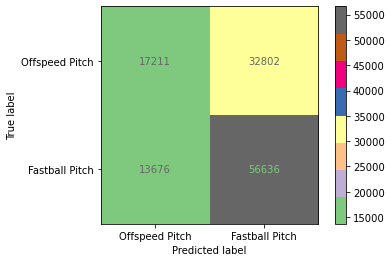

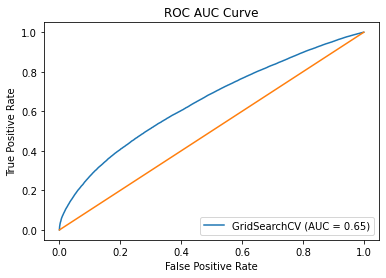

In [29]:
# Displaying classification metrics 
binary_classification_metrics(gs_accuracy_2, X_test_dum, y_test_dum);

## Feature Reduction to Account for Multi-Collinearity

Logistic regression is a generalized linear model, therefore in this section I wanted to evaluate whether reducing the number of features would improve the score due to reducing the impact of multicollinearity. 

### Variance Inflation Factor (VIF) Multicollinearity Reduction 

In this portion I reduce the impact of multicollinearity by removing the features that have a VIF greater than 10. I do not look at the dummy variables because the scores were similar between the dummy variable logistic regression and non-dummy variables. 

In [30]:
# Create copy of the original binary DataFrame 
df_2 = df.copy()

In [31]:
# Creating VIF DataFrame of independent variable features

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(X.values, i) 
                     for i in range(X.shape[1])]

vif['features'] = X.columns

vif['features'] = X.columns

vif

,vif_factor,features
0,9.755854,balls
1,10.724772,strikes
2,1.550963,on_1b
3,2.577844,outs_when_up
4,4.552998,inning
5,5.465121,offspeed_in_sequence
6,10.504928,fastball_in_sequence
7,33.855398,proportion_of_fastballs_thrown_2018
8,24.273637,previous_pitch
9,10.750593,previous_zone


In [32]:
# Features with VIF > 10
vif[vif['vif_factor'] > 10]

,vif_factor,features
1,10.724772,strikes
6,10.504928,fastball_in_sequence
7,33.855398,proportion_of_fastballs_thrown_2018
8,24.273637,previous_pitch
9,10.750593,previous_zone
15,10.911063,of_fielding_alignment_Standard
19,25.404081,previous_type_B
20,25.522044,previous_type_S
21,102.065072,hitter_woba_2018
22,259.013660,average_hitter_launch_speed_2018


In [33]:
df_2 = df.drop(columns=['previous_type_S', 'average_hitter_launch_speed_2018',
                      'previous_type_B','previous_pitch', 'proportion_of_fastballs_thrown_2018',
                       'hitter_woba_2018'])

In [34]:
X_2 = df_2.drop(columns=['pitch'])
y_2 = df_2['pitch']

In [35]:
# Reviewed VIF DataFrame. None greater than 10!

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(X_2.values, i) 
                     for i in range(X_2.shape[1])]

vif['features'] = X_2.columns

vif['features'] = X_2.columns

vif

,vif_factor,features
0,8.604490,balls
1,8.151784,strikes
2,1.546364,on_1b
3,2.489875,outs_when_up
4,4.015525,inning
5,5.095550,offspeed_in_sequence
6,9.172383,fastball_in_sequence
7,4.062047,previous_zone
8,2.601607,stand_R
9,3.458584,p_throws_R


In [36]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, 
                                                    random_state=16, stratify=y)

In [37]:
# Assessing with scoring 
gs_2 = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='accuracy')

In [38]:
gs_2.fit(X_train_2, y_train_2);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  6.7min finished


My accuracy is:  0.5917
My sensitivity is:  0.8631
My precision is:  0.6057
My f1 score is:  0.7118


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.5366164138545959


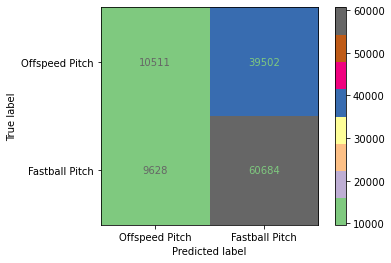

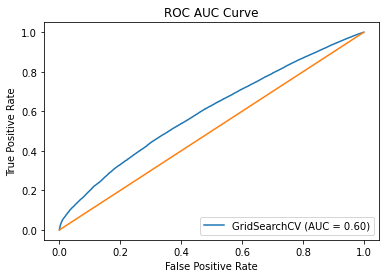

In [39]:
binary_classification_metrics(gs_2, X_test_2, y_test_2);

Over-fit to fastball projection 

### Principal Component Analysis (PCA) Feature Reduction 

In [40]:
mm = MinMaxScaler()

In [41]:
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

In [42]:
# Need 15 xcomponents to have decent accuracy score 
pca = PCA().fit(X_train_mm)

pca.explained_variance_ratio_

array([0.16135106, 0.15485173, 0.14800324, 0.09022729, 0.08675253,
       0.074353  , 0.06047946, 0.05550631, 0.04624949, 0.02912563,
       0.02387699, 0.01320415, 0.01208362, 0.01094284, 0.00927497,
       0.00789535, 0.00472103, 0.00362597, 0.003152  , 0.00243963,
       0.00106114, 0.00041439, 0.00040818])

In [43]:
pipe_2 = Pipeline([
    ('mm', MinMaxScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression())
])

In [44]:
params_2 = {
    'pca__n_components': [15],
     'lr__solver': ['liblinear','saga'],
    'lr__penalty': ['l1','l2', 'elasticnet'],
    'lr__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__class_weight': [None, 'balanced']
}

In [45]:
gs_3 = GridSearchCV(pipe_2, params_2, cv = 5,
                    scoring = 'accuracy', verbose = 1, n_jobs = -1)

In [46]:
gs_3.fit(X_train, y_train);


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 10.6min finished


My accuracy is:  0.5863
My sensitivity is:  0.9226
My precision is:  0.594
My f1 score is:  0.7227


,Pred Offspeed,Pred Fastball
Actual Offspeed,True Negative,False Positive
Actual Fastball,False Negative,True Positive


My ROC AUC score is: 0.5180891802185363


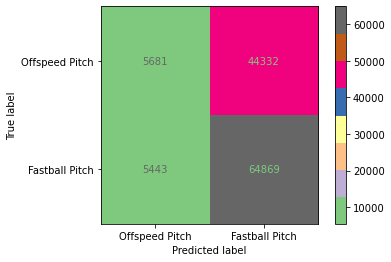

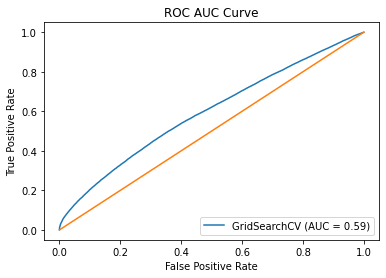

In [47]:
binary_classification_metrics(gs_3, X_test, y_test);

Accuracy suffered greatly because of the PCA reduction. 

## Multi-Class Logistic Regression

In [48]:
df_3['pitch'].value_counts(normalize=True)

3    0.584354
2    0.286061
1    0.129585
Name: pitch, dtype: float64

In [49]:
df_3.isna().sum()

balls                                       0
strikes                                     0
on_1b                                       0
outs_when_up                                0
inning                                      0
pitch                                       0
changeup_in_sequence                        0
breaking_ball_in_sequence                   0
fastball_in_sequence                        0
proportion_of_breaking_balls_thrown_2018    0
proportion_of_fastballs_thrown_2018         0
previous_pitch                              0
previous_zone                               0
stand_R                                     0
p_throws_R                                  0
if_fielding_alignment_Infield shift         0
if_fielding_alignment_Standard              0
of_fielding_alignment_4th outfielder        0
of_fielding_alignment_Standard              0
risp                                        0
run_diff                                    0
inning_topbot_Top                 

In [50]:
X_3 = df_3.drop(columns=['pitch'])
y_3 = df_3['pitch']

In [51]:
# Have to label encode for the target variable in logistic regression
le = LabelEncoder()
y_3 = le.fit_transform(y_3)

In [52]:
# Label encoded array
y_3

array([1, 2, 2, ..., 0, 0, 2])

In [53]:
# Train-test split
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_3, y_3, test_size=0.25, 
                                                    random_state=16)

In [54]:
pipe_3 = Pipeline([
    ('mm', MinMaxScaler()),
    ('lr', LogisticRegression())
])

In [55]:
params_3 = {
    'lr__solver': ['saga'],
    'lr__penalty': ['l1','l2', 'elasticnet'],
    'lr__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class' : ['ovr', 'multinomial']
}

In [56]:
# Gridsearching for accuracy
gs_4 = GridSearchCV(pipe_3, param_grid=params_3, n_jobs=-1, verbose=1, cv=5, scoring='accuracy')

In [57]:
gs_4.fit(X_train_mc, y_train_mc);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 18.5min finished


In [58]:
gs_4.score(X_train_mc, y_train_mc)


0.5946910303789192

In [59]:
gs_4.score(X_test_mc, y_test_mc)

0.5933097859962602

In [60]:
# Inspiration from:
# https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    #hpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_test_columns = ['Fastball', 'Breaking Ball', 'Changeup']
    
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], 
                                                                y_test_columns[i])) #% (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()



In [61]:
def multiclass_classification_metrics(gs, X_test, y_test):
    
    y_hat = gs.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_hat)

    sensitivity =  metrics.recall_score(y_test, y_hat, average='macro')

    precision = metrics.precision_score(y_test, y_hat, average='macro')

    f1 = metrics.f1_score(y_test, y_hat, average='macro')
    
    
    print('My accuracy is: ', round(accuracy,4))
    print('My sensitivity is: ', round(sensitivity,4))
    print('My precision is: ', round(precision,4))
    print('My f1 score is: ', round(f1 ,4))
    

    metrics.plot_confusion_matrix(gs, X_test, y_test, cmap='Accent', 
                          values_format='d', display_labels=[ 'Change-up',
                                                              'Breaking Ball', 
                                                             'Fastball']);
    
    plot_multiclass_roc(gs, X_test, y_test, 3, figsize=(17, 6))

My accuracy is:  0.5933
My sensitivity is:  0.3798
My precision is:  0.5356
My f1 score is:  0.3568


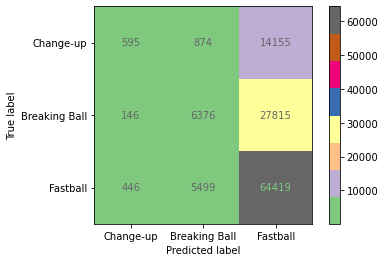

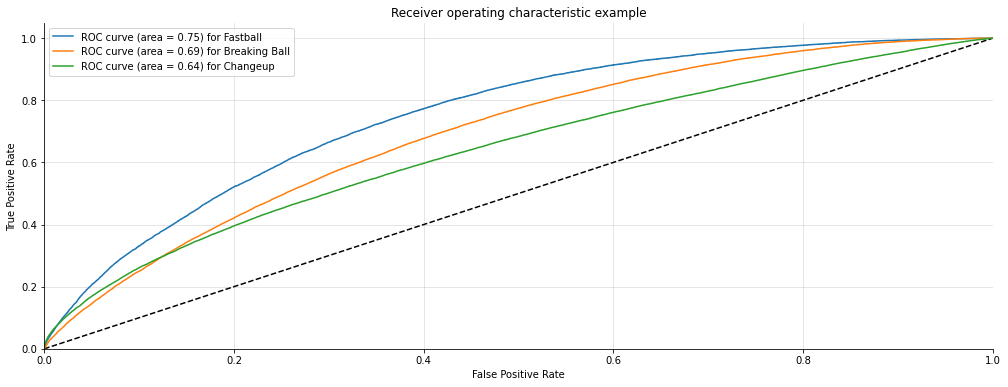

In [62]:
multiclass_classification_metrics(gs_4, X_test_mc, y_test_mc)

Still super overfit to fastball. 

### Analyzing for F1 Score

In [63]:
gs_5 = GridSearchCV(pipe_3, param_grid=params_3, n_jobs=-1, verbose=1, cv=5, scoring='f1_weighted')

In [64]:
gs_5.fit(X_train_mc, y_train_mc);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 18.3min finished


My accuracy is:  0.5924
My sensitivity is:  0.3981
My precision is:  0.5176
My f1 score is:  0.392


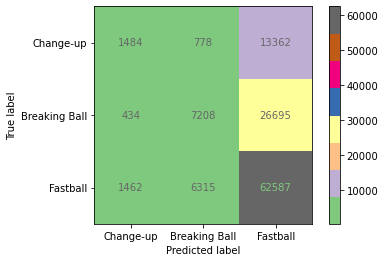

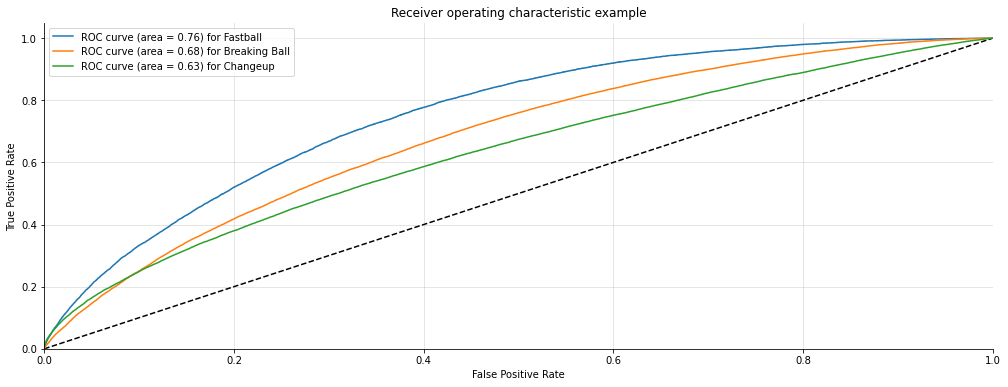

In [65]:
multiclass_classification_metrics(gs_5, X_test_mc, y_test_mc)

Does a little better than previous model. 

# Model Considerations

## Binary Label Models

* Most accurate is not the most useful model. 
    * The most accurate model is the model with the dummy independent variables and accuracy GridSearch. It over-predicts fastballs, however, so may not be useful in the context of a pitcher who has a more even repertoire of pitches to utilize. 

* Instead, the most useful model is my model that has the dummy independent variables and uses the 'f1_weighted' scoring metric in the grid search.
    * This model has the highest f1 score, and thus accounts for more offspeed pitches than the overfit model by maximizing the mean of the recall and precision in the gridsearch.



## Multiclass Label Models 

* My multiclass logistic regression did not outperform the baseline accuracy by very much, therefore I will look towards random forest to predict the next pitch coming with multiple classes

In [66]:
coefs = gs_f2.best_estimator_.named_steps['lr'].coef_

In [67]:
len(coefs[0])

58

In [72]:
len(X_train_3.columns.to_list())

NameError: name 'X_train_3' is not defined

In [73]:
# Creating a DataFrame of top words contributing to slope and their corresponding slope
coef_df = pd.DataFrame({'top_features': X_train_dum.columns, 'log(odds)': coefs[0]})

In [74]:
# gs_f2

In [75]:
# Calculating how feature increases the odds of text being political 
coef_df['odds'] = coef_df['log(odds)'].map(lambda x: math.exp(x))

In [76]:
# Setting index to be the words
coef_df.set_index('top_features', inplace=True)

In [77]:
# Most political words (i.e. political text identifying words)
top_features = coef_df.sort_values('odds', ascending=False).head(20)
top_features

,log(odds),odds
top_features,,
proportion_of_fastballs_thrown_2018,3.432784,30.962726
balls_3.0,0.916485,2.500485
fastball_in_sequence,0.518928,1.680226
balls_2.0,0.285098,1.329892
run_diff,0.221331,1.247736
on_1b,0.083754,1.087361
previous_zone_5.0,0.034466,1.035067
balls_4.0,0.005142,1.005155
inning_topbot_Top,0.004064,1.004072


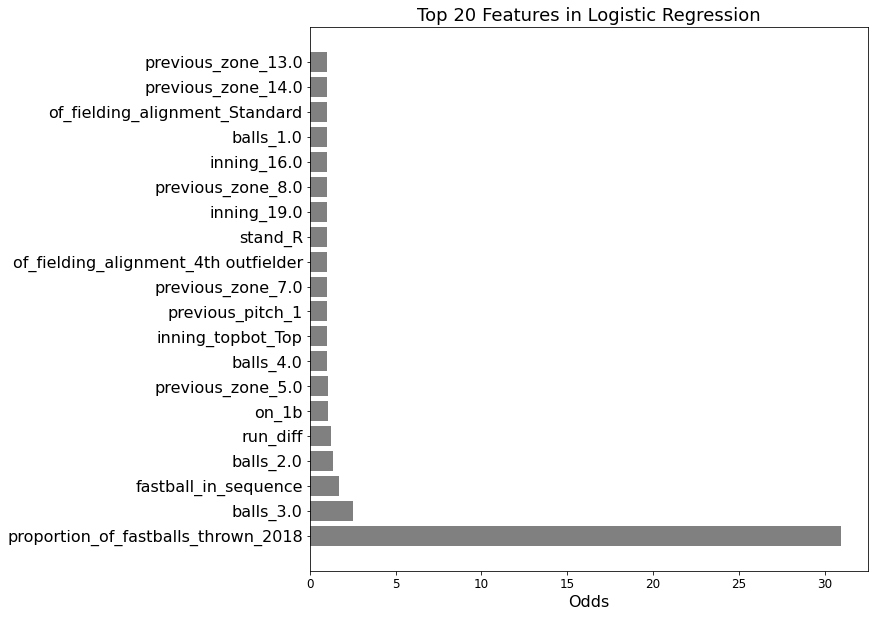

In [78]:
plt.figure(figsize=(10,10))
plt.barh(top_features.index, top_features['odds'], color='grey')
plt.title('Top 20 Features in Logistic Regression', fontsize=18)
plt.xlabel('Odds', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=12);

As we can see, the features created have not necessarily been helpful in creating the best classification algorithm. the proportion of fastballs thrown by the pitcher was a helpful feature, however the rest of the features are not indicative of the classification. Therefore, this problem may not inherently be something predicted by bulk data without further insight into behaviors in even smaller situations. 